# All_Data_Morrisons TimeSeriesForecasting

# Load Data

In [7]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(
    '/kaggle/input/time-series-uk-supermarket-data/All_Data_Morrisons.csv',
    parse_dates=['date'])

df.head()

,supermarket,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,Morrisons,2.10,4.20,kg,Alpro Vanilla Yoghurt Alternative,2024-04-13,free-from,False
1,Morrisons,2.10,4.20,kg,Alpro Plain No Sugars Yoghurt Alternative,2024-04-13,free-from,False
2,Morrisons,2.30,2.30,l,Alpro Barista Coconut Milk,2024-04-13,free-from,False
3,Morrisons,3.25,8.13,kg,Morrisons The Best Thick Pork Sausages,2024-04-13,free-from,True
4,Morrisons,3.25,8.67,kg,Morrisons The Best Pork Chipolatas 12 Pack,2024-04-13,free-from,True


## Data Exploration

In [8]:
df.shape

(1794065, 8)

In [9]:
df.columns

Index(['supermarket', 'prices_(£)', 'prices_unit_(£)', 'unit', 'names', 'date',
       'category', 'own_brand'],
      dtype='object')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794065 entries, 0 to 1794064
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   supermarket      object        
 1   prices_(£)       float64       
 2   prices_unit_(£)  float64       
 3   unit             object        
 4   names            object        
 5   date             datetime64[ns]
 6   category         object        
 7   own_brand        bool          
dtypes: bool(1), datetime64[ns](1), float64(2), object(4)
memory usage: 97.5+ MB


In [14]:
df = df.drop('supermarket', axis=1)

In [15]:
df

,prices_(£),prices_unit_(£),unit,names,date,category,own_brand
0,2.10,4.20,kg,Alpro Vanilla Yoghurt Alternative,2024-04-13,free-from,False
1,2.10,4.20,kg,Alpro Plain No Sugars Yoghurt Alternative,2024-04-13,free-from,False
2,2.30,2.30,l,Alpro Barista Coconut Milk,2024-04-13,free-from,False
3,3.25,8.13,kg,Morrisons The Best Thick Pork Sausages,2024-04-13,free-from,True
4,3.25,8.67,kg,Morrisons The Best Pork Chipolatas 12 Pack,2024-04-13,free-from,True
...,...,...,...,...,...,...,...
1794060,9.50,9.50,unit,Morrisons Wooden Rectangular Paddleboard,2024-01-09,home,True
1794061,3.00,3.00,unit,Morrisons Wooden Turner,2024-01-09,home,True
1794062,2.00,2.00,unit,Talking Tables Metallic Gold Slogan Napkin,2024-01-09,home,False
1794063,25.00,25.00,unit,Tcp Smart Led Double Switch,2024-01-09,home,False


In [37]:
for col in df.columns:
    print(col, df[col].isna().sum(), df[col].dtype)

prices_(£) 0 float64
prices_unit_(£) 110 float64
unit 110 object
names 0 object
date 0 datetime64[ns]
category 0 object
own_brand 0 bool


<Axes: >

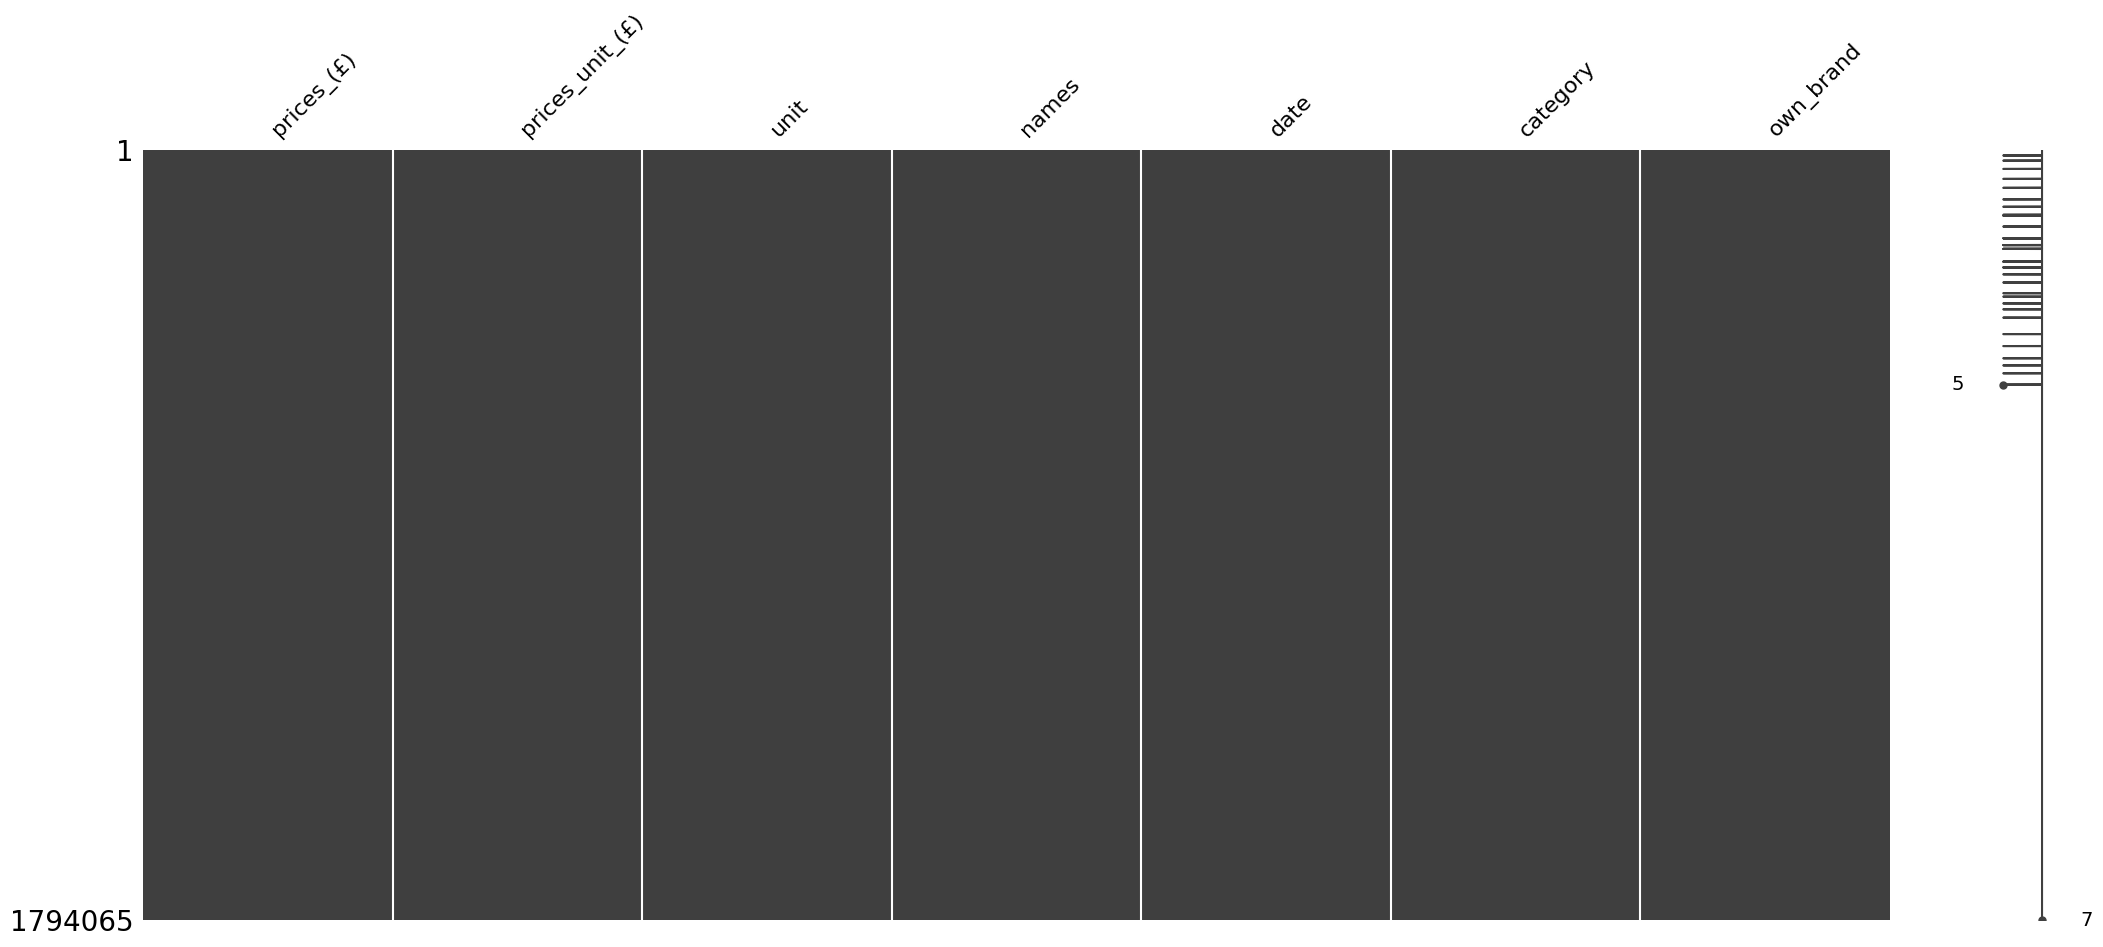

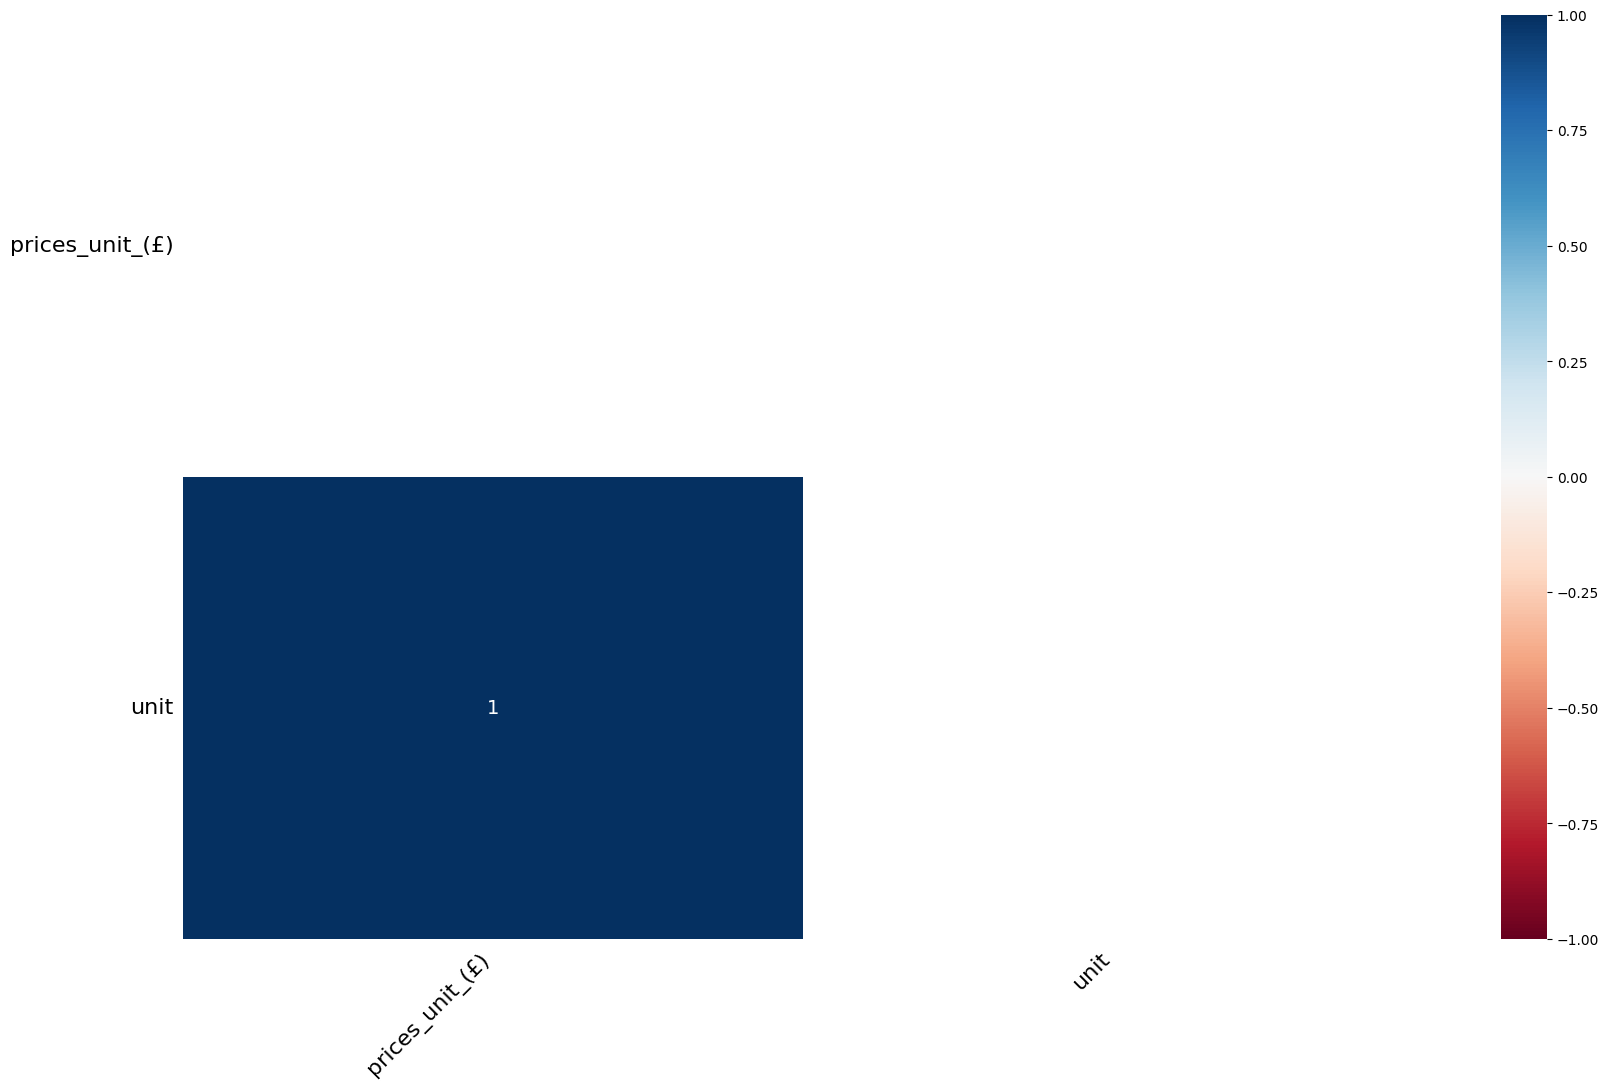

In [46]:
import missingno as msno
msno.matrix(df)
msno.heatmap(df)

In [35]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
prices_(£),1794065.0,4.894816,0.2,1.75,2.8,5.25,300.0,6.632725
prices_unit_(£),1793955.0,26.181018,0.0,3.3,7.4,14.95,11225.0,166.164239
date,1794065,2024-02-25 01:01:35.079497984,2024-01-09 00:00:00,2024-02-04 00:00:00,2024-02-24 00:00:00,2024-03-19 00:00:00,2024-04-13 00:00:00,NaN


In [41]:
df[df.select_dtypes(include='object').columns].nunique()

unit            4
names       26187
category       11
dtype: int64

In [48]:
df.duplicated().sum()

0

# Preprocessing

## Imputation

In [49]:
df = df.sort_values(['names', 'date'])

df['unit'] = df.groupby('names')['unit'].ffill().bfill()

df['prices_unit_(£)'] = df.groupby('names')['prices_unit_(£)'].ffill().bfill()

In [50]:
df.isna().sum()

prices_(£)         0
prices_unit_(£)    0
unit               0
names              0
date               0
category           0
own_brand          0
dtype: int64